# Summary

The foul ball formula seems to be:
```python
foul_threshold = 0.25 + 0.1*fwd - 0.1*obt + (1/30)*(musc + thwack + div)
```
Rolls below this threshold are fouls, rolls above it are fair. Astrid figured this out last week, but I want to show it in a notebook to make it easier to find.
I have succeeded! It seems that this formula is correct.

Oddities in this formula:

- Traveling applies something like a 3.5% boost, not the 5% advertised
- Growth applies something like a 0-3.5% boost, not the 0-5% boost advertised
- Night Vision Goggles are real! Not applying that boost causes an outlier here. It's kind of annoying to apply though since it's not a modification, but instead a DE-era item.

Also, the attribute-specific boosts of Chunky and Smooth matter here, and it seems that they aren't necessarily a flat 100% to every affected attribute. Using 15% for the musclitude boost of Smooth made it work here. Worked out 15% via this:

Spin Attack ("+15% speed" blessing) results:
```
Hewitt Best:
musc:  0.7458 to 0.7683 : 0.0225
cont:  1.098  to 1.173  : 0.075
gf:    0.378  to 0.453  : 0.075
laser: 1.06   to 1.18   : 0.12
```

Ooze, in the same election, boosted "power" by "10%". according to Thomas Dracaena's history, it boosted:
```
div:  0.10
musc: 0.10
gf:   0.05
```
So div and musc would be actually +100% for Chunky, if this ratio holds (and indeed using that worked for me here).


## Load data

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm

import load

In [2]:
season = 18
df = load.data("fouls", season=season)

df["musc_vibes"] = load.player_attribute(df, 'batter', 'musclitude', vibes=True, mods=True, items=True, broken_items=True)
df["thwack_vibes"] = load.player_attribute(df, 'batter', 'thwackability', vibes=True, mods=True, items=True, broken_items=True)
df["div_vibes"] = load.player_attribute(df, 'batter', 'divinity', vibes=True, mods=True, items=True, broken_items=True)

# center=True is the default
df["forwardness"] = load.stadium_attribute(df, 'forwardness', center=False)
df["obtuseness"] = load.stadium_attribute(df, 'obtuseness', center=False)

df.groupby("season").size()

season
18    78244
dtype: int64

In [3]:
df["batter_attrs"] = (df["musc_vibes"] + df["thwack_vibes"] + df["div_vibes"]) / 3

df["hypediff_vibes"] = (df["batting_team_hype"] - df["pitching_team_hype"]) * (1 + 0.2 * df["batter_vibes"])

# put in our "best fit" up here in the original df, just because
df["threshold_best"] = (0.25
                        + 0.10 * df['forwardness'] 
                        - 0.10 * df['obtuseness'] 
                        + 0.10 * (df["musc_vibes"] + df["thwack_vibes"] + df["div_vibes"]) / 3
                       )

## Exclude data
For instance, can exclude specific mods, or situations with multipliers != 1.0. Here, I'm going to be excluding batters with O No, because that creates tons of foul balls that "shouldn't be" foul balls.

I'm also excluding LATE_TO_PARTY because it's a weird huge mess that I don't understand yet!

In [4]:
dfc = df.copy()
# dfc = dfc[~dfc["passed"].isna()]
# Sorry, Chorby Short
for exclude_mod in ["O_NO", "LATE_TO_PARTY"]:#, "TRAVELING"]:
# for exclude_mod in ["O_NO", "ON_FIRE", "SLOW_BUILD", "TRAVELING", "CHUNKY", "SMOOTH", "LATE_TO_PARTY",
#                    "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["O_NO", "ON_FIRE", "PSYCHIC", "PARASITE", "MINIMALIST", "MAXIMALIST", "CHUNKY", "SMOOTH", "LATE_TO_PARTY",
#                     "OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
    # dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    # dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

# dfc = dfc[(dfc['pitcher_mul'] == 1) & (dfc['batter_mul'] == 1)]



In [5]:
# there are so many columns now, alas
# print(list(df.columns))
print(len(df))
print(len(dfc))
# dfc.head()

78244
64448


In [6]:
# preparing a useful digest list of columns for later
digest_list = [
    "event_type",
    "passed",
    "roll",
    "threshold",
    "offset",
    # "threshold_best",
    "batter_name",
    # "pitcher_name",
    "div_vibes",
    "musc_vibes",
    "thwack_vibes",
    "forwardness",
    "obtuseness",
    "game_id",
    "play_count",
    "batter_mods",
    "batting_team_mods",
    # "pitcher_mods",
    # "pitching_team_mods",
    "weather",
    "hypediff_vibes",
    "day",
]


### Preliminary plot

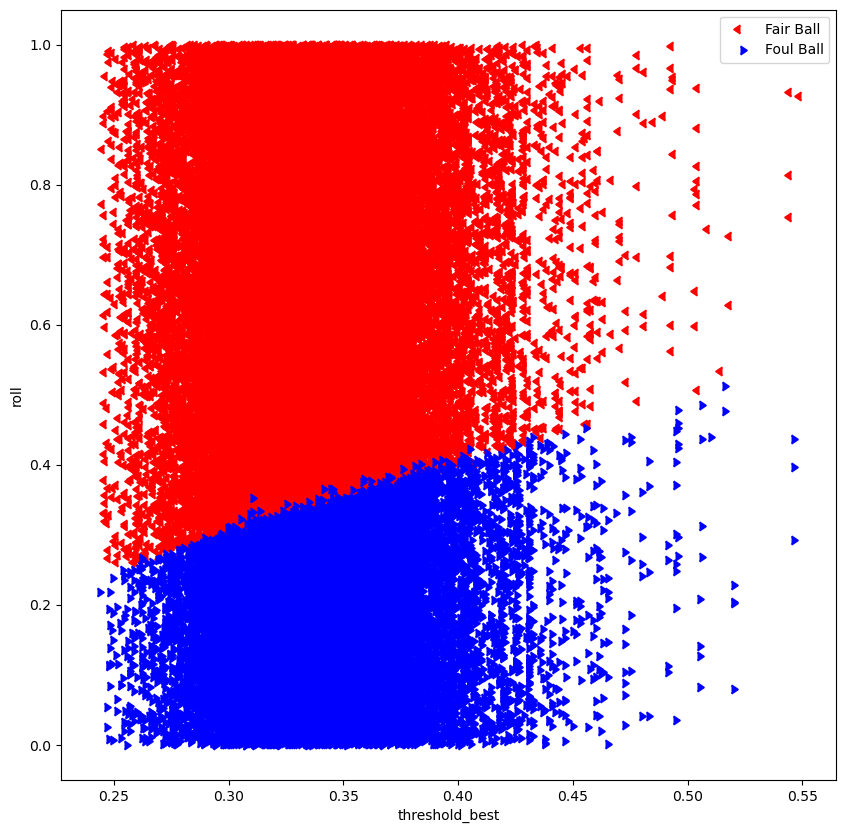

In [7]:
x_val = "musc_vibes"
x_val = "threshold_best"
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.scatter(
    dfc[~dfc["passed"].astype("bool")][x_val],
    dfc[~dfc["passed"].astype("bool")]["roll"],
    color="red",
    label="Fair Ball",
    marker=CARETLEFTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Foul Ball",
    marker=CARETRIGHTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.set_xlim(0.484, 0.499)

ax.legend()

# fig.savefig("../figures/" + x_val + ".png", facecolor="white")

## SVC fit

In [8]:
# The "include "passed" in X and then drop it" stuff is useful if you need to exclude a range of rolls,
# say because there's a max value for the threshold (like in the strike zone formula).
X = dfc[[
    "passed",
    "roll",
    # "div_vibes",
    # "musc_vibes",
    # "thwack_vibes",
    "batter_attrs",
    "forwardness",
    "obtuseness",
    "hypediff_vibes",
    # "batting_team_hype",
    # "pitching_team_hype",
]].copy()

# X = X[X["roll"] < 0.85]
y = X["passed"].astype("bool")
X = X.drop(["passed"], axis=1)
X.shape

(64448, 5)

In [9]:
sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000000, tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[42563    10]
 [    8 21867]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     42573
        True       1.00      1.00      1.00     21875

    accuracy                           1.00     64448
   macro avg       1.00      1.00      1.00     64448
weighted avg       1.00      1.00      1.00     64448

0.9997207050645481


In [10]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]

print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.2506643]


[(1.0, 'roll'),
 (0.09995990616322245, 'obtuseness'),
 (-0.09959410498366116, 'forwardness'),
 (-0.09951403966977293, 'batter_attrs'),
 (-0.019655536212323636, 'hypediff_vibes')]

## Calculate threshold from fit

In [11]:
dfc['threshold'] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        dfc['threshold'] += pair[0] * dfc[pair[1]]

# if you want to do a manual version instead, put it here

dfc["threshold"] = (0.250
                    + 0.10 * df['forwardness']
                    - 0.10 * df['obtuseness']
                    + 0.10 * (df["musc_vibes"] + df["thwack_vibes"] + df["div_vibes"]) / 3
                    + 0.02 * df["hypediff_vibes"]
                    )

[0.2506643]
(0.09951403966977293, 'batter_attrs')
(0.09959410498366116, 'forwardness')
(-0.09995990616322245, 'obtuseness')
(0.019655536212323636, 'hypediff_vibes')


## Find Outliers

12
batting_team_mods
ACIDIC;SUN2_PAYOUTS;SUN_KISSED             1
AFFINITY_FOR_CROWS;AA                      1
BIRD_SEED;SHAME_GIVER                      1
ELECTRIC;TRAVELING;A;GOOD_RIDDANCE;LOVE    1
GROWTH                                     1
HIGH_PRESSURE;H20                          1
AAA                                        2
SINKING_SHIP                               4
dtype: int64
batter_mods
                                                 1
HOMEBODY;OVERPERFORMING                          1
ON_FIRE;PERK;SPICY                               1
SLOW_BUILD;SWIM_BLADDER;SIPHON                   1
SOUNDPROOF                                       1
TRAVELING                                        1
UNDERPERFORMING;FIREPROOF;HOMEBODY;FIRE_EATER    1
UNDERPERFORMING;HOMEBODY                         1
TRAVELING;REVERBERATING                          2
TRAVELING;SQUIDDISH                              2
dtype: int64


,event_type,passed,roll,threshold,offset,batter_name,div_vibes,musc_vibes,thwack_vibes,forwardness,obtuseness,game_id,play_count,batter_mods,batting_team_mods,weather,hypediff_vibes,day,baserunner_count
46949,Foul,True,0.352634,0.309361,0.043273,Velasquez Alstott,0.652705,1.097660,0.990594,0.447795,0.767839,c97d3807-c3a9-426b-be1f-b9c9930af77f,247,UNDERPERFORMING;FIREPROOF;HOMEBODY;FIRE_EATER,ELECTRIC;TRAVELING;A;GOOD_RIDDANCE;LOVE,Weather.FEEDBACK,0.000000e+00,76,0
69513,Foul,True,0.335873,0.335085,0.000788,Scores Baserunner,1.079525,0.743398,1.394933,0.440855,0.437936,e3b0c0d8-b802-48fa-b7e9-9f3a23d9af1b,77,,GROWTH,Weather.ECLIPSE,-1.123435e+00,41,1
72639,Foul,True,0.302780,0.302229,0.000551,Lady Matsuyama,0.925722,0.753525,0.585960,0.415052,0.647833,a953275a-22d6-4b8d-b87d-82a02ad075a2,104,UNDERPERFORMING;HOMEBODY,SINKING_SHIP,Weather.PEANUTS,0.000000e+00,44,1
22452,Fair,False,0.335359,0.335487,-0.000127,Randy Dennis,1.028838,0.804490,1.455598,0.541529,0.782973,f0f2da90-6181-4126-8db3-5d627721cd75,270,SLOW_BUILD;SWIM_BLADDER;SIPHON,HIGH_PRESSURE;H20,Weather.FLOODING,2.927223e-17,15,0
63325,Fair,False,0.318321,0.318813,-0.000492,Dickerson Morse,0.135056,1.289662,1.037069,0.536745,0.669207,da215672-e07f-4daf-b203-0524afd80968,69,TRAVELING;SQUIDDISH,AAA,Weather.FLOODING,0.000000e+00,35,0
64017,Fair,False,0.317529,0.318813,-0.001285,Dickerson Morse,0.135056,1.289662,1.037069,0.536745,0.669207,da215672-e07f-4daf-b203-0524afd80968,299,TRAVELING;SQUIDDISH,AAA,Weather.FLOODING,0.000000e+00,35,0
19520,Fair,False,0.383747,0.385206,-0.001459,Lady Matsuyama,1.382869,1.125636,0.875322,0.560639,0.336525,fc77a95b-9530-400b-8c35-6fe67ab68ed5,293,HOMEBODY;OVERPERFORMING,SINKING_SHIP,Weather.FEEDBACK,0.000000e+00,12,1
57015,Fair,False,0.334932,0.337661,-0.002730,Basilio Mason,0.739053,1.023006,0.914775,0.653052,0.668717,e63934ab-96b0-4efe-85b6-65ff7ffe67da,8,TRAVELING,ACIDIC;SUN2_PAYOUTS;SUN_KISSED,Weather.FEEDBACK,0.000000e+00,29,0
72947,Fair,False,0.378748,0.381841,-0.003093,Don Mitchell,1.622485,1.735003,1.296096,0.415052,0.647833,a953275a-22d6-4b8d-b87d-82a02ad075a2,204,TRAVELING;REVERBERATING,SINKING_SHIP,Weather.PEANUTS,0.000000e+00,44,0
21643,Fair,False,0.402662,0.406659,-0.003997,Don Mitchell,1.404879,1.502307,1.122265,0.769724,0.546283,eb43c424-aa64-4931-b4dc-3a24ca08edbc,6,TRAVELING;REVERBERATING,SINKING_SHIP,Weather.FLOODING,0.000000e+00,15,0


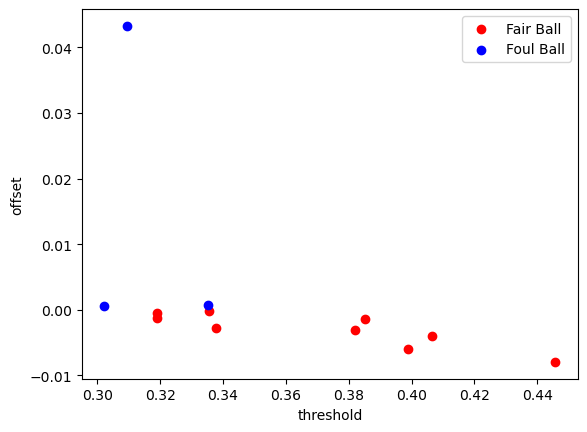

In [12]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
ax.scatter(
    outliers[~(outliers["passed"].astype("bool"))][x_val],
    outliers[~(outliers["passed"].astype("bool"))]["offset"],
    color="red",
    label="Fair Ball",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Foul Ball",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

table = outliers
print(len(outliers))
print(outliers.groupby(["batting_team_mods"]).size().sort_values())
print(outliers.groupby(["batter_mods"]).size().sort_values())
table[[*digest_list, "baserunner_count"]].sort_values("offset", ascending=False)

## Visualize Threshold

Text(0.5, 0.98, 'All Seasons')

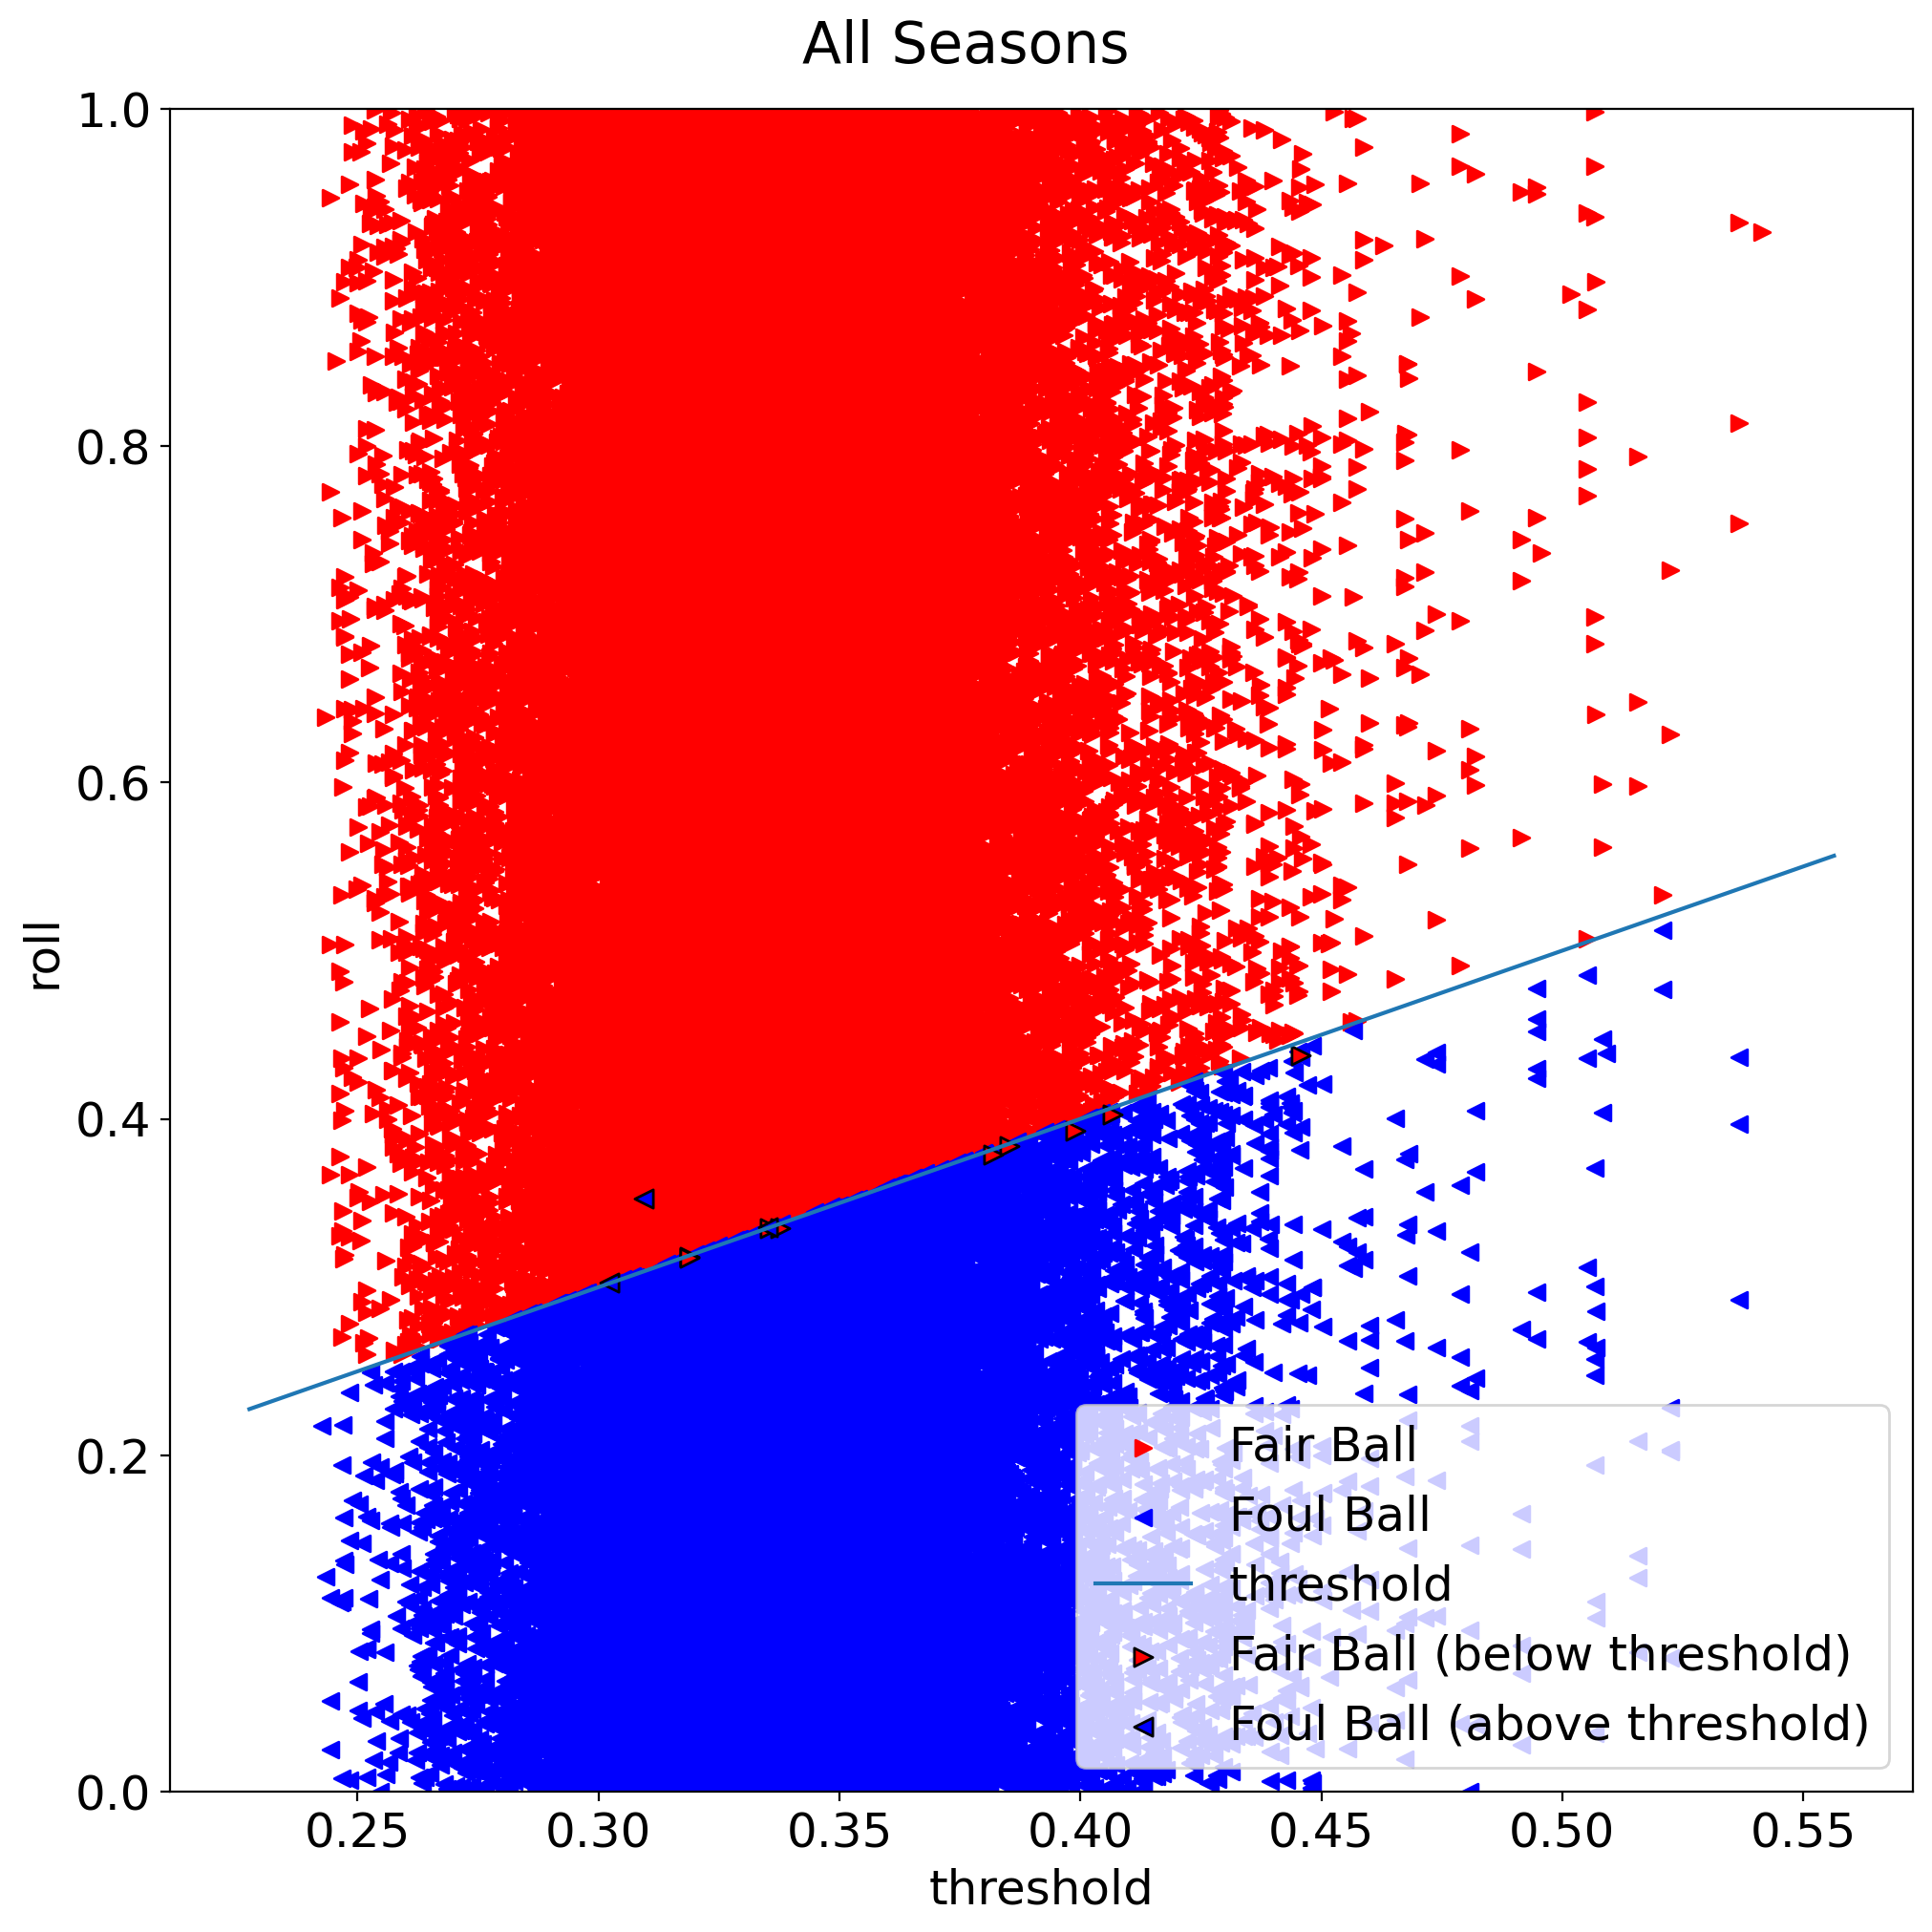

In [13]:
# x_val = "pitcher_ruthlessness"

plt.rcParams["font.size"] = 18
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=200, layout="constrained")

ax.set_ylim(0, 1)
ax.scatter(
    dfc[~(dfc["passed"].astype(bool))][x_val],
    dfc[~(dfc["passed"].astype(bool))]["roll"],
    color="red",
    label="Fair Ball",
    marker=">",
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Foul Ball",
    marker="<",
)
xline = ax.get_xlim()
yline = xline
ax.plot(xline, yline, label="threshold")
if len(outliers) > 0:
    ax.scatter(outliers[~(outliers['passed'].astype(bool))][x_val], outliers[~(outliers['passed'].astype(bool))]["roll"],
               s=48, edgecolor='black', color="red", label="Fair Ball (below threshold)", marker='>')
    ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"],
               s=48, edgecolor='black', color="blue", label="Foul Ball (above threshold)", marker='<')
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.set_ylim(0.85, 0.86)

ax.legend(loc="lower right")
# fig.suptitle(f"Season {season+1}")
fig.suptitle(f"All Seasons")
# fig.savefig("../figures/strikes_s14_flinch.png", facecolor='white', dpi=200)
# endpoints = np.array(ax.get_xlim())
# ax.plot(endpoints, 0.35 + 0.35 * endpoints)

In [14]:
outliers.groupby("season").size()

season
18    12
dtype: int64

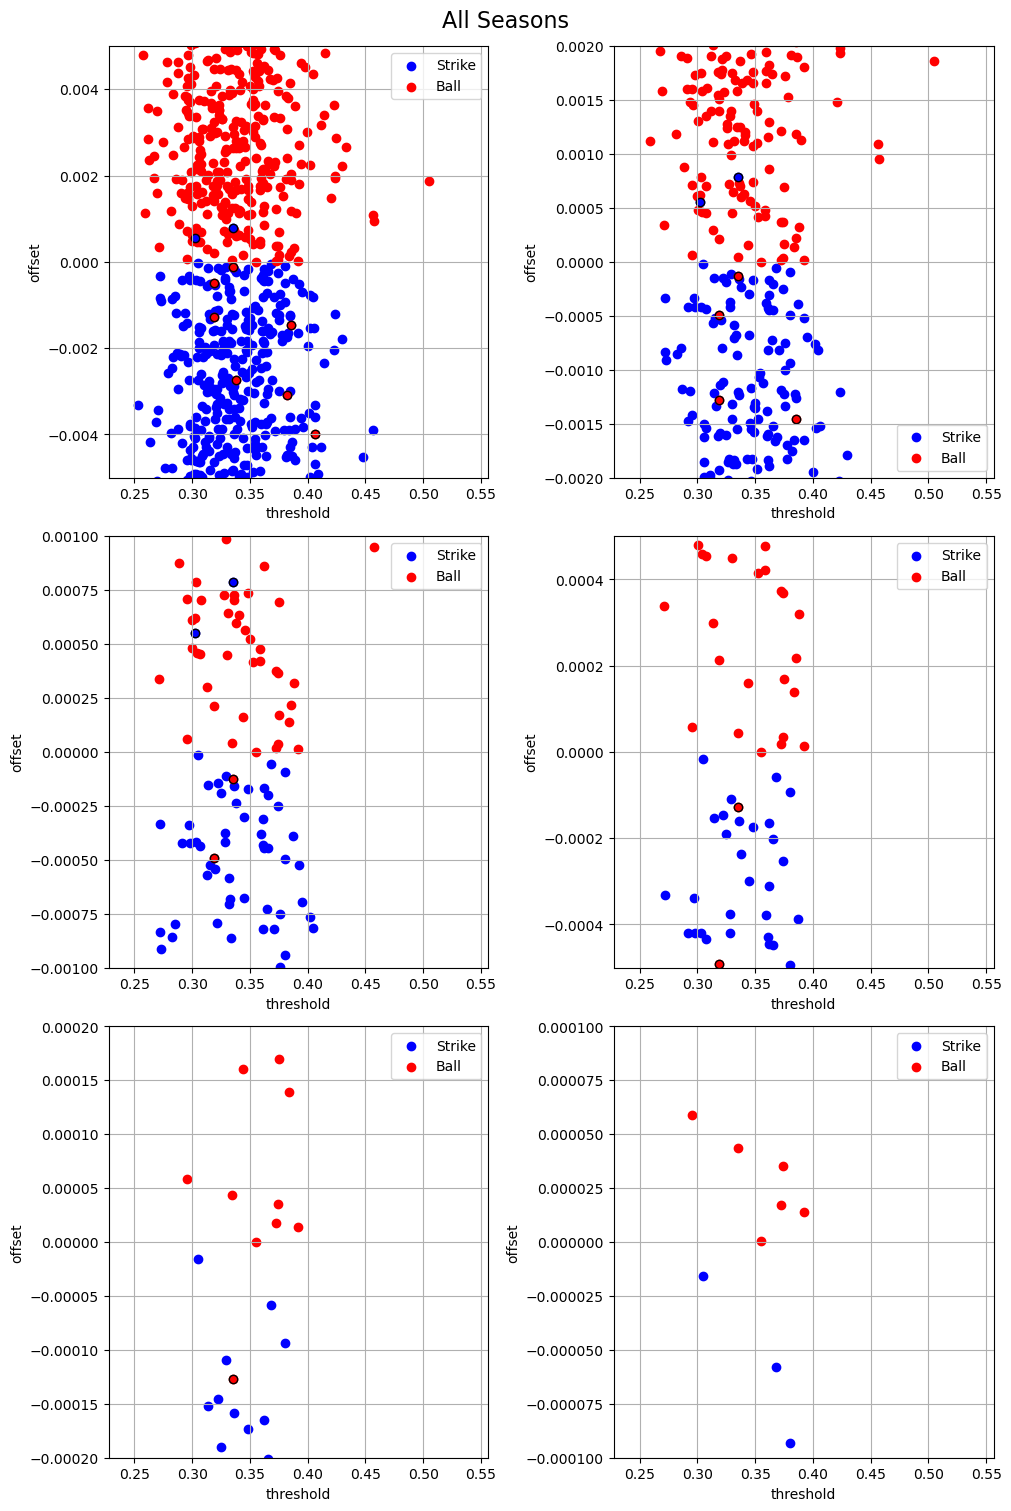

In [15]:
plt.rcParams["font.size"] = 10
x_val = "threshold"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
# fig.suptitle(f"Season {season+1}", fontsize=16)
fig.suptitle(f"All Seasons", fontsize=16)
dimlist = [5e-3, 2e-3, 1e-3, 0.5e-3, 0.2e-3, 0.1e-3]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Strike",
    )
    ax.scatter(
        dfc[~(dfc["passed"].astype(bool))][x_val],
        dfc[~(dfc["passed"].astype(bool))]["offset"],
        color="red",
        label="Ball",
    )
    ax.scatter(
        outliers[~(outliers["passed"].astype(bool))][x_val],
        outliers[~(outliers["passed"].astype(bool))]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/ball_strike_fit_offsets.png", facecolor='white')